In [13]:
from __future__ import print_function
from net.models import SAVA_test as SAVA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import argparse
import os
from tqdm import tqdm
import time

from net.network import SelfAttention, vgg_reverse, vgg, SAVANet
from net.models import Transform, SAVA_test
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--sava_model', type=str, default='/public/dehezhang2/github/SAVA_Official_Implementation/models/sava_training/',
                    help='Directory path to a batch of content images')
parser.add_argument('--vgg_model', type=str, default='./models/vgg/vgg_normalised.pth')
parser.add_argument('--attn_model', type=str, default='./models/attention_training/attention_kernel_iter_80000.pth')

parser.add_argument('--content_image', type=str, default='./datasets/test/content/lenna.jpg',
                    help='Directory path to a batch of content images')
parser.add_argument('--style_image', type=str, default='./datasets/test/style/candy.jpg',
                    help='Directory path to a batch of style images')
args = parser.parse_args('')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

cuda


torch.Size([3, 512, 512])
torch.Size([3, 512, 512])


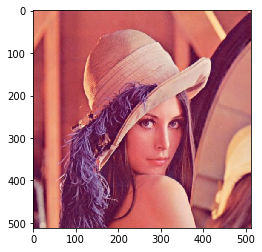

In [4]:
# loading test data

def test_transform(size = 512):
    transform = transforms.Compose([
        transforms.Resize(size=(size, size)),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize((_R_MEAN/255.0, _G_MEAN/255.0, _B_MEAN/255.0), (0.5, 0.5, 0.5))
    ])
    return transform

def test_transform_inv():
    transform = transforms.Compose([
        transforms.Normalize((0, 0, 0), (2, 2, 2)),
        transforms.Normalize((-_R_MEAN/255.0, -_G_MEAN/255.0, -_B_MEAN/255.0), (1, 1, 1))
    ])
    return transform
# scale = 1.40625
content_tf = test_transform(int(512))
style_tf = test_transform(int(512))
content_tf_inv = test_transform_inv()
content = content_tf(Image.open(args.content_image).convert('RGB'))
print(content.shape)

style = style_tf(Image.open(args.style_image).convert('RGB'))
print(style.shape)

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(content_tf_inv(content)))

In [5]:
def state_to_device(parameter, device):
    state_dict = parameter.state_dict()
    for key in state_dict.keys():
        state_dict[key] = state_dict[key].to(device)
    parameter.cuda()

encoder = vgg
encoder.load_state_dict(torch.load(args.vgg_model))
state_to_device(encoder, device)

self_attn = SelfAttention()
self_attn.load_state_dict(torch.load(args.attn_model))
state_to_device(self_attn, device)

transformer = Transform(in_channel = 512, self_attn=self_attn)
transformer.load_state_dict(torch.load(args.sava_model + 'transformer_iter_15000.pth'))
state_to_device(transformer, device)

decoder = vgg_reverse
decoder.load_state_dict(torch.load(args.sava_model + 'decoder_iter_15000.pth'))
state_to_device(decoder, device)
model = SAVA_test(transformer=transformer, encoder=encoder, decoder=decoder)
model.cuda()

SAVA_test(
  (transformer): Transform(
    (savanet4_1): SAVANet(
      (feat_corr): Correlation(
        (f): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
        (g): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
        (softmax): Softmax(dim=-1)
      )
      (h): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (self_attn): SelfAttention(
        (corr): Correlation(
          (f): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
          (g): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
          (softmax): Softmax(dim=-1)
        )
        (h): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      )
      (softmax): Softmax(dim=-1)
      (out_conv): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    )
    (savanet5_1): SAVANet(
      (feat_corr): Correlation(
        (f): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
        (g): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
        (softmax): Softmax(dim=-1)
      )
      (h

In [6]:
content = torch.stack([content], dim = 0)
content = content.to(device)
style = torch.stack([style], dim = 0)
style = style.to(device)
output, swapped_features, [content_attn4_1, style_attn4_1, content_attn5_1, style_attn5_1] = model.transfer(content, style)
losses = model(content, style)

In [7]:
def imshow_recon(img, save_dir=None):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if save_dir != None:
        torchvision.utils.save_image(img, save_dir)
    
def show_output(output, save_dir=None):
    print("Saving to " + str(save_dir))
    content_result = content_tf_inv(output.squeeze())
    imshow_recon(torchvision.utils.make_grid(content_result.cpu()), save_dir)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving to None


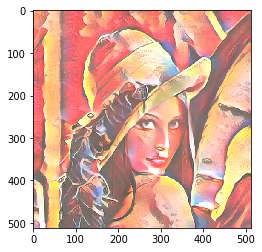

In [8]:
show_output(output)

In [9]:
print(losses['content'].data)

tensor(1.9915, device='cuda:0')


In [15]:
def save_attn_map(attn_map, save_dir=None):
    channel_num = attn_map.size()[1]
    mean_sal = torch.mean(attn_map, 1, False)
    mean_sal_np = mean_sal.cpu().detach().numpy()
    mean_sal_np = mean_sal_np - np.min(mean_sal_np)
    mean_sal_np = mean_sal_np * 1.0 / np.max(mean_sal_np)
    # print(mean_sal.size())
    plt.imshow(mean_sal_np[0], cmap=cm.get_cmap('rainbow', 1000))
    plt.colorbar()
    plt.axis('off')
#     plt.savefig(save_dir)

tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0014, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)


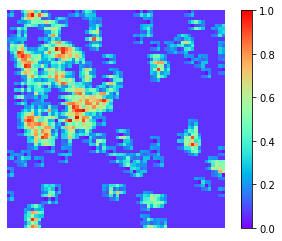

In [20]:
test = transformer.savanet4_1.attention_filter(style_attn4_1)
su = test.sum()
test /= su
save_attn_map(test)
print(test.min())
print(test.max())
print(test.sum())